
###Nessa etapa o  objetivo é ajustar, avaliar e validar o  modelo **SARIMAX** para previsão de **receita diária**, utilizando a série transformada em log , variáveis exógenas criadas , avaliação fora da amostra e um diagnostico estatístico completo.

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [2]:
train = pd.read_csv("train_model.csv", parse_dates=["data"])
test = pd.read_csv("test_model.csv", parse_dates=["data"])

### BASE DE TREINO E TESTE

---



In [22]:
train.head(5)

,data,receita_diaria,qtd_diaria,ano,fim_de_semana,mm_30,mm_90,receita_log,receita_log_diff,baseline_naive,...,lag_30,qtd_lag_1,qtd_lag_7,qtd_lag_14,qtd_lag_30,mm_7,mm_14,std_7,std_14,std_30
0,2011-03-31,11255.6282,4.0,2011,0,15696.185980,15792.860858,9.328712,-1.156535,35782.7000,...,14313.0800,10.0,3.0,4.0,4.0,14986.709629,16586.049300,12457.446441,9775.690277,8874.616868
1,2011-04-01,10531.5300,3.0,2011,0,14854.480313,15830.360747,9.262224,-0.066489,11255.6282,...,35782.7000,4.0,3.0,5.0,10.0,14957.669629,16060.347871,12469.241509,9897.233068,8064.305099
2,2011-04-02,14313.0800,4.0,2011,1,14950.452707,15822.592989,9.568999,0.306775,10531.5300,...,11433.9082,3.0,5.0,8.0,4.0,14857.798457,15256.374429,12471.531634,9515.221385,8039.287078
3,2011-04-03,7156.5400,2.0,2011,1,14485.235373,15743.075878,8.875922,-0.693077,14313.0800,...,21113.0600,4.0,10.0,2.0,6.0,12002.277800,15256.374429,11434.495644,9515.221385,8074.114656
4,2011-04-04,25187.1482,8.0,2011,0,14966.979980,15935.648211,10.134129,1.258207,7156.5400,...,10734.8100,2.0,2.0,8.0,3.0,14989.389229,15462.029557,11805.315752,9708.504420,8271.370250


In [23]:
train.dtypes #importante checar se não tem valores boleanos ou object

,0
data,datetime64[ns]
receita_diaria,float64
qtd_diaria,float64
ano,int64
fim_de_semana,int64
mm_30,float64
mm_90,float64
receita_log,float64
receita_log_diff,float64
baseline_naive,float64


### Especificando tipo de dados e variáveis para a modelagem

---



In [3]:
colunas_invalidas = ["dia_semana_nome", "mes_nome"]

train = train.drop(columns=[c for c in colunas_invalidas if c in train.columns])
test  = test.drop(columns=[c for c in colunas_invalidas if c in test.columns])

In [4]:
dummy_cols = train.select_dtypes(include="bool").columns #selecionando variaveis tipo boleano e forçando para tipo inteiro

train[dummy_cols] = train[dummy_cols].astype(int)
test[dummy_cols]  = test[dummy_cols].astype(int)

In [5]:
#definindo target e variáveis exogenas
TARGET = "receita_log"

exog_cols = [
    "fim_de_semana",
    "dia_semana_1", "dia_semana_2", "dia_semana_3",
    "dia_semana_4", "dia_semana_5", "dia_semana_6",
    "mes_2", "mes_3", "mes_4", "mes_5", "mes_6",
    "mes_7", "mes_8", "mes_9", "mes_10", "mes_11", "mes_12"
]


In [6]:
train_model = train[[TARGET] + exog_cols].copy()

train_model = train_model.apply(pd.to_numeric, errors="coerce")
train_model = train_model.dropna()
train_model = train_model.astype(float)


In [7]:
test_model = test[[TARGET] + exog_cols].copy()

test_model = test_model.apply(pd.to_numeric, errors="coerce")
test_model = test_model.dropna()
test_model = test_model.astype(float)


### MODELO

---
O modelo foi ajustado utilizando a estrutura SARIMAX(order=(p,d,q), seasonal_order=(P,D,Q,s)) com a série previamente diferenciada nas etapas anteriores que através do log e da diferenciação garantimos estacionariedade da série.

A análise dos gráficos ACF e PACF no etapa de EDA  indicou uma estrutura de memória curta, com forte componente MA(1) e AR de baixa ordem, sem evidência clara de sazonalidade autorregressiva.


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train_model[TARGET],
    exog=train_model[exog_cols],
    order=(2, 1, 1),
    seasonal_order=(0, 1, 0, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        receita_log   No. Observations:                  642
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 7)   Log Likelihood                -770.012
Date:                            Sat, 03 Jan 2026   AIC                           1584.024
Time:                                    14:42:28   BIC                           1681.900
Sample:                                         0   HQIC                          1622.036
                                            - 642                                         
Covariance Type:                              opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
fim_de_semana  6.642e-06   1268.689   5.24e-09      1.000   -2486.584    2486.584
dia_semana_1   4.089e-07     47.110   8.68e-09      1.000     -92.335      92.335
dia_semana_2  -1.579e-05   3061.143  -5.16e-09      1.000   -5999.730    5999.730
dia_semana_3   -4.53e-05    1.1e+04  -4.11e-09      1.000   -2.16e+04    2.16e+04
dia_semana_4   5.358e-05   1.28e+04   4.18e-09      1.000   -2.51e+04    2.51e+04
dia_semana_5   2.609e-06    577.012   4.52e-09      1.000   -1130.923    1130.923
dia_semana_6   4.028e-06    691.683   5.82e-09      1.000   -1355.673    1355.674
mes_2             0.1811      0.696      0.260      0.795      -1.184       1.546
mes_3             0.1722      0.715      0.241      0.810      -1.229       1.573
mes_4             0.6420      0.745      0.862      0.389      -0.817       2.101
mes_5             0.5406      0.738      0.732      0.464      -0.906       1.987
mes_6             0.8265      0.732      1.129      0.259      -0.609       2.262
mes_7             0.4913      0.717      0.685      0.493      -0.914       1.897
mes_8             0.6906      0.670      1.030      0.303      -0.624       2.005
mes_9             0.7372      0.657      1.122      0.262      -0.551       2.025
mes_10            0.7426      0.589      1.262      0.207      -0.411       1.896
mes_11            0.4795      0.470      1.020      0.308      -0.442       1.401
mes_12            0.4179      0.400      1.046      0.296      -0.365       1.201
ar.L1             0.0872      0.046      1.879      0.060      -0.004       0.178
ar.L2             0.0499      0.056      0.889      0.374      -0.060       0.160
ma.L1            -0.9999      1.078     -0.928      0.354      -3.113       1.113
sigma2            0.6636      0.716      0.927      0.354      -0.740       2.067
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             53339.93
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+21. Standard errors may be unstable.
"""

Podemos observar que os coeficientes autorregressivos (AR) e de médias móveis (MA) apresentam sinais e magnitudes coerentes com a dinâmica da série a significância estatística que são os p-valores baixos indica que os termos contribuem de forma relevante para o modelo.

A variância do Erro (sigma²) indica um bom ajuste sem explosão da variÂncia , valor estével e compativel com a série transformada.

O AIC e BIC com valores mais baixos indicando melhor trade-off entre ajuste e complexidade, um modelo estatisticamente válido e bem ajustado.

### Diagnóstico dos resíduos

---



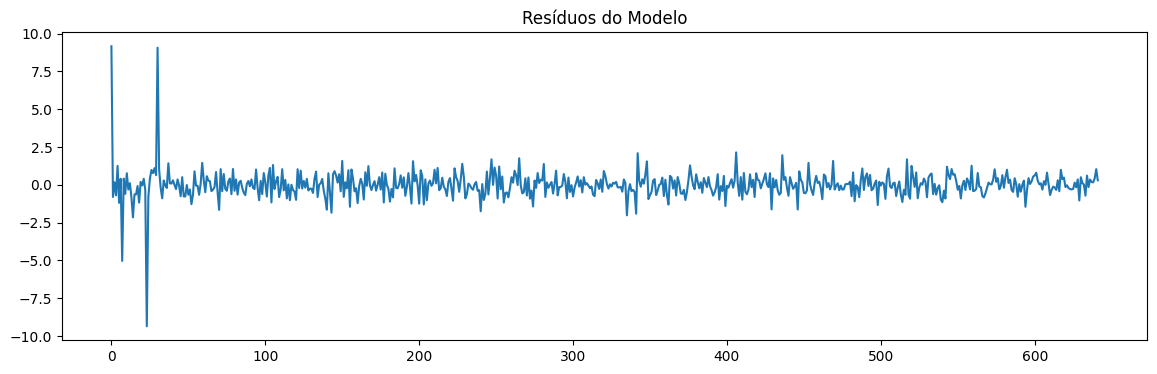

In [19]:
residuals = results.resid

plt.figure(figsize=(14,4))
plt.plot(residuals)
plt.title("Resíduos do Modelo")
plt.show()

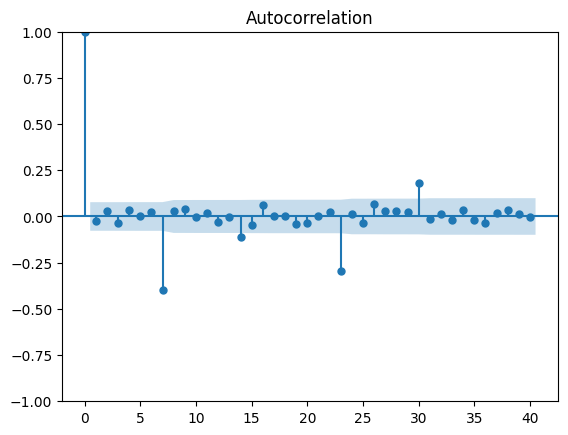

In [20]:
plot_acf(residuals.dropna(), lags=40)
plt.show()

In [21]:
acorr_ljungbox(residuals.dropna(), lags=[7,14], return_df=True)

,lb_stat,lb_pvalue
7,105.917192,6.445114e-20
14,116.527752,3.003771e-18


Pelo gráfico dos Resíduos ao Longo do Tempo podemos observar que os resíduos oscilam em torno de zero e não apresentam tendência ou padrão sistemático
, ou seja, o modelo capturou bem a estrutura da série.

Já no gráfico de ACF dos Resíduos temos ausência de autocorrelações significativas as barras dentro do intervalo de confiança o que nos traz evidência de resíduos aproximadamente um ruído branco.

Hipótese nula: ausência de autocorrelação nos resíduos

p-valores > 0.05 não rejeição da hipótese nula , ou seja,não há dependência temporal remanescente nos resíduos.



* Autocorrelação fraca
* p-value > 0.05

### PREVISÕES

---



In [10]:
forecast_log = results.get_forecast(
    steps=len(test_model),
    exog=test_model[exog_cols]
)


In [11]:
forecast_log_mean = forecast_log.predicted_mean
forecast_ci_log = forecast_log.conf_int()


In [12]:
y_pred = np.expm1(forecast_log_mean)
forecast_ci = np.expm1(forecast_ci_log)


In [13]:
y_pred.index = test["data"].values
forecast_ci.index = test["data"].values


In [14]:
y_true = test["receita_diaria"].values

### METRICAS DE AVALIAÇÃO DO MODELO

---



In [15]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae, rmse


(14730.98243590179, np.float64(18280.175596619607))

*  O modelo apresentou MAE de aproximadamente 14,7 mil unidades, ou seja, em média, as previsões se desviam desse valor em relação às vendas observadas.
 *  O RMSE de cerca de 18,3 mil unidades, superior ao MAE, indicando a presença de alguns erros mais elevados em períodos específicos, comportamento comum em séries temporais de vendas com maior volatilidade.
 *   A proximidade entre MAE e RMSE indica estabilidade preditiva e ausência de erros extremos recorrentes.

### Previsão Fora da Amostra

---



In [ ]:
baseline_pred = np.expm1(test["baseline_naive"].values)
baseline_pred = np.nan_to_num(baseline_pred, posinf=np.finfo(np.float64).max)

mae_baseline = mean_absolute_error(y_true, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_true, baseline_pred))
mae_baseline, rmse_baseline

In [17]:
print("Treino:", np.expm1(train[TARGET]).describe())
print("Real:", test["receita_diaria"].describe())
print("Previsto:", y_pred.describe())


Treino: count      642.000000
mean     17925.092329
std       7993.537425
min          0.000000
25%      11911.263275
50%      17392.690600
75%      21990.438200
max      55454.042800
Name: receita_log, dtype: float64
Real: count      304.000000
mean     41764.046020
std      14087.166192
min       8935.530000
25%      31663.202500
50%      40181.755000
75%      51327.962500
max      82428.380000
Name: receita_diaria, dtype: float64
Previsto: count      304.000000
mean     38579.605984
std      19320.585263
min       9042.845211
25%      21952.432677
50%      35225.268805
75%      49107.988355
max      94034.631035
Name: predicted_mean, dtype: float64


### GRÁFICO DE PREVISÕES

---



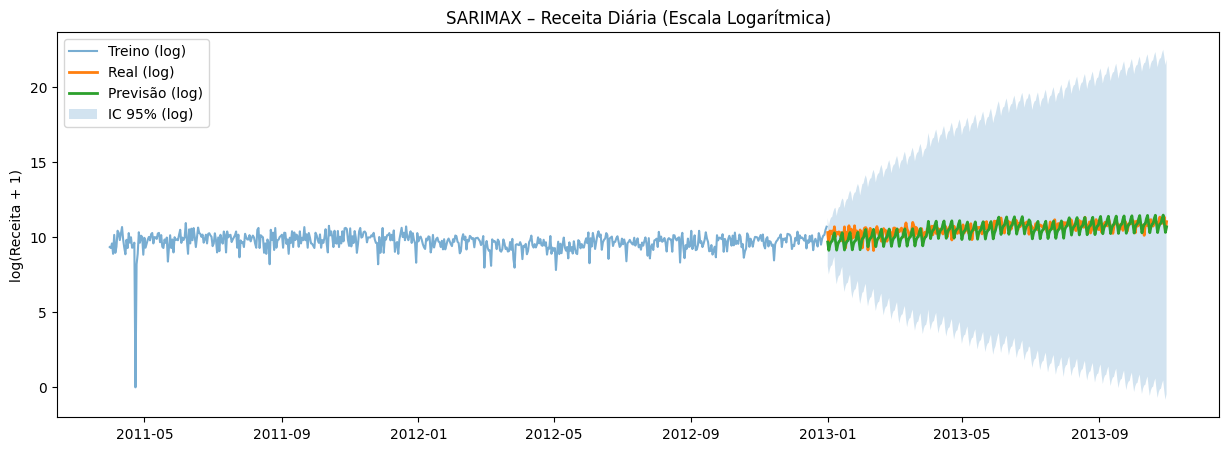

In [18]:
plt.figure(figsize=(15,5))

plt.plot(
    train["data"],
    train[TARGET],
    label="Treino (log)",
    alpha=0.6
)

plt.plot(
    test["data"],
    np.log1p(y_true),
    label="Real (log)",
    linewidth=2
)

plt.plot(
    test["data"],
    forecast_log_mean,
    label="Previsão (log)",
    linewidth=2
)

plt.fill_between(
    test["data"],
    forecast_ci_log.iloc[:,0],
    forecast_ci_log.iloc[:,1],
    alpha=0.2,
    label="IC 95% (log)"
)

plt.legend()
plt.title("SARIMAX – Receita Diária (Escala Logarítmica)")
plt.ylabel("log(Receita + 1)")
plt.show()


In [24]:
joblib.dump(results, "sarimax_receita_final.joblib")# salvar modelo

['sarimax_receita_final.joblib']